In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMAI/Assignment3/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/SMAI/Assignment3
/content/drive/MyDrive/SMAI/Assignment3


In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imat
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import save_image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import os
import time
import gc
import shutil
import h5py
import pandas as pd
from sklearn.decomposition import PCA
%matplotlib inline

# **PART 1**

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])
os.makedirs("data/mnist", exist_ok=True)
train_dataset = MNIST(root='data/mnist', train=True, download=True, transform=transform)
test_dataset = MNIST(root='data/mnist', train=False, transform=transform)
print(len(train_dataset), len(test_dataset))

60000 10000


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_checkpoint(state, is_best, epoch, name):
    filename = 'q3_checkpoints/q3_ckpt_'+name
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, filename+'_best')

def test_model(model_class, ckpt, cmat=True):
    model = model_class().cuda()
    # print(model)
    checkpoint = torch.load('q3_checkpoints/'+ckpt)
    model.load_state_dict(checkpoint['model_state_dict'])
    test_loader = DataLoader(test_dataset, 64, num_workers=2, pin_memory=True)  
    sm = nn.Softmax(dim=1)  
    total_correct = 0
    total_images = 0
    model.eval()        
    gt_labels = []
    pred_labels = []
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device).flatten(start_dim=1)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            sm_outputs = sm(outputs)
            outputs = torch.argmax(outputs, dim=1)
            total_correct += (outputs == labels).sum().item()
            total_images += len(labels)
            gt_labels += labels.tolist()
            pred_labels += outputs.tolist()
        torch.cuda.empty_cache()
        gc.collect()
    model_accuracy = total_correct / total_images * 100
    if cmat:
        conf_mat = confusion_matrix(gt_labels, pred_labels)
        df_cm = pd.DataFrame(conf_mat, index = [i for i in range(10)], columns = [i for i in range(10)])
        plt.figure()
        sn.heatmap(df_cm, annot=True, cmap='Blues')
    return model_accuracy

def plot_train(losses, errors):
    plt.plot(range(len(losses)), losses, label = "Train loss", color='blue', markersize=5, marker='o',markerfacecolor='blue')
    plt.plot(range(len(errors)), errors, label = "Val loss", color='red', markersize=5, marker='o',markerfacecolor='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Val loss')
    plt.legend()
    plt.show()

def show_train_imgs(img_name, epochs):
    row_imgs = epochs//5+1
    fig, axs = plt.subplots(1, row_imgs, figsize=(20,20))
    for i in range(0,epochs):
        if i%5==0:
            img = imat.imread('q3_images/'+img_name+'_'+str(i)+'.png')
            axs[i//5].imshow(img)
            axs[i//5].set_title('Epoch '+str(i))
            axs[i//5].axis('off')
        elif i==epochs-1:
            img = imat.imread('q3_images/'+img_name+'_'+str(i)+'.png')
            axs[i//5+1].imshow(img)
            axs[i//5+1].set_title('Epoch '+str(i))
            axs[i//5+1].axis('off')
        else:
            continue

In [ ]:
class MLP_Trainer(object):
    def __init__(self, device, model_class, ckpt_name, load_ckpt=None, epochs=200, batch_size=64, lr=0.1, optm=None, mom=0.9, lr_decay=None, init_wts=None, step=4, weight_decay=0, trainset=train_dataset, valset=test_dataset):
        self.device = device
        self.lr =  lr
        self.step_size = step
        self.momentum = mom
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.start_epoch = 0
        self.epochs = epochs
        self.workers = 2
        self.seed = int(time.time())
        self.print_freq = 1
        self.checkpoint_path = load_ckpt #'q1_checkpoints/q1_ckpt_CNN_a_best2'
        self.best_error = 1e8
        self.best_epoch = 0
        self.ckpt_name = ckpt_name
        self.loss_history = []
        self.error_history = []
        self.trainset = trainset
        self.valset = valset
        self.init_weights = init_wts
        torch.cuda.manual_seed(self.seed)
        print(self.device,torch.cuda.get_device_name(0))

        self.model = model_class(self.init_weights).cuda()
        # print(self.model)
        if optm=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optm=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        elif optm=='rms':
            self.optimizer = torch.optim.RMSprop(self.model.parameters(), self.lr, momentum=self.momentum)
        self.criterion = nn.CrossEntropyLoss().cuda()
        # self.scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.lr_decay)
        
        if self.checkpoint_path:
            checkpoint = torch.load(self.checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']+1
            loss = checkpoint['loss']
            self.best_error = checkpoint['best_error']
            self.best_epoch = checkpoint['best_epoch']
        
    def train(self):
        for epoch in range(self.start_epoch, self.epochs):
            loss = self.train_epoch(epoch)
            if epoch%1 != 0:
                print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)))
                continue
            error = self.validate(epoch)
            if error < self.best_error:
                is_best = True
                self.best_epoch = epoch
            else:
                is_best = False
            self.loss_history.append(loss)
            self.error_history.append(error)
            self.best_error = min(error, self.best_error)
            print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)),'  Val error:'+str(round(error,3)),'  Best val error:'+str(round(self.best_error,3)))
            save_checkpoint({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': loss,
                'best_error': self.best_error,
                'best_epoch': self.best_epoch
            }, is_best, epoch, self.ckpt_name)
            # self.scheduler.step()
            self.expo_anneal_lr(epoch)
        return self.best_epoch, self.loss_history, self.error_history

    def train_epoch(self, cur_epoch):
        train_loader = DataLoader(self.trainset, self.batch_size, shuffle=True, num_workers=self.workers, pin_memory=True)        
        self.model.train()        
        losses = 0
        out_imgs = None
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(self.device).flatten(start_dim=1)
            labels = labels.to(self.device)
            # print(inputs.shape,labels.shape)
            with torch.set_grad_enabled(True):
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                losses += loss.detach().cpu().item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            torch.cuda.empty_cache()
            gc.collect()
        return losses/len(train_loader)
    
    def validate(self, cur_epoch):
        val_loader = DataLoader(self.valset, self.batch_size, num_workers=self.workers, pin_memory=True)        
        self.model.eval()        
        errors = 0
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(self.device).flatten(start_dim=1)
            labels = labels.to(self.device)
            with torch.set_grad_enabled(False):
                outputs = self.model(inputs)
                error = self.criterion(outputs, labels)
                errors += error.detach().cpu().item()
            torch.cuda.empty_cache()
            gc.collect()
        return errors/len(val_loader)

    def expo_anneal_lr(self, epoch):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr * self.lr_decay**(epoch/self.epochs)
            # print('LR adjusted')

In [ ]:
class MLP(nn.Module):
    def __init__(self,init_weights=None):
        super(MLP, self).__init__()
        self.denselayers = nn.Sequential(
            nn.Linear(784, 512), #input
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 256), #hidden
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 128), #hidden
            nn.LeakyReLU(inplace=True), 
            nn.Dropout(0.1),
            nn.Linear(128, 64), #hidden
            nn.ReLU(inplace=True), 
            nn.Linear(64, 10), #output
        )
        self.init_weights = init_weights
        if self.init_weights:
            self._initialize_weights()

    def forward(self,x):
        x = self.denselayers(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Linear):
                if self.init_weights=='x':
                    torch.nn.init.xavier_normal_(m.weight)
                elif self.init_weights=='u':
                    torch.nn.init.uniform_(m.weight)
                elif self.init_weights=='n':
                    torch.nn.init.normal_(m.weight)
                    # print("init n")
                if m.bias is not None:
                    nn.init.uniform_(m.bias)
                    # nn.init.constant_(m.bias, 0.0)

# SGD without momentum

### Without weights initialization

cuda Tesla K80
Epoch:0   Loss:2.14   Val error:1.227   Best val error:1.227
Epoch:1   Loss:0.767   Val error:0.494   Best val error:0.494
Epoch:2   Loss:0.479   Val error:0.359   Best val error:0.359
Epoch:3   Loss:0.365   Val error:0.282   Best val error:0.282
Epoch:4   Loss:0.291   Val error:0.223   Best val error:0.223
Epoch:5   Loss:0.24   Val error:0.191   Best val error:0.191
Epoch:6   Loss:0.205   Val error:0.196   Best val error:0.191
Epoch:7   Loss:0.177   Val error:0.147   Best val error:0.147
Epoch:8   Loss:0.158   Val error:0.142   Best val error:0.142
Epoch:9   Loss:0.145   Val error:0.13   Best val error:0.13


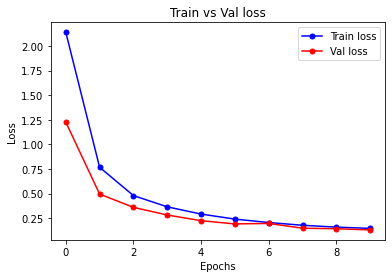

Best epoch: 9


In [ ]:
mlpa_trainer = MLP_Trainer(device, MLP, 'MLP_a', lr=0.01, epochs=10, optm='sgd', lr_decay=0.9, step=4, mom=0, weight_decay=1e-5)
a_best_epoch, a_losses, a_errors = mlpa_trainer.train()
plot_train(a_losses, a_errors)
print('Best epoch:',a_best_epoch)

Test accuracy: 95.93 %


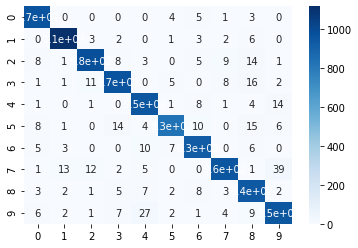

In [ ]:
a_acc = test_model(MLP, 'q3_ckpt_MLP_a_best')
print('Test accuracy:',a_acc,'%')

### With Xavier's weights initialization

cuda Tesla K80
Epoch:0   Loss:0.981   Val error:0.323   Best val error:0.323
Epoch:1   Loss:0.261   Val error:0.205   Best val error:0.205
Epoch:2   Loss:0.194   Val error:0.155   Best val error:0.155
Epoch:3   Loss:0.156   Val error:0.13   Best val error:0.13
Epoch:4   Loss:0.135   Val error:0.116   Best val error:0.116
Epoch:5   Loss:0.12   Val error:0.126   Best val error:0.116
Epoch:6   Loss:0.109   Val error:0.102   Best val error:0.102
Epoch:7   Loss:0.098   Val error:0.087   Best val error:0.087
Epoch:8   Loss:0.09   Val error:0.115   Best val error:0.087
Epoch:9   Loss:0.085   Val error:0.097   Best val error:0.087


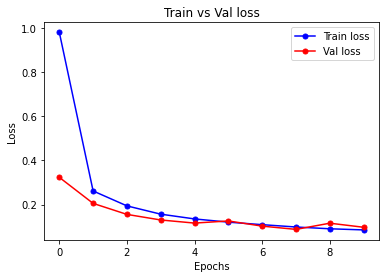

Best epoch: 7


In [ ]:
mlpax_trainer = MLP_Trainer(device, MLP, 'MLP_ax', init_wts='x', optm='sgd', lr=0.2, epochs=10, lr_decay=0.9, step=4, mom=0, weight_decay=1e-5)
ax_best_epoch, ax_losses, ax_errors = mlpax_trainer.train()
plot_train(ax_losses, ax_errors)
print('Best epoch:',ax_best_epoch)

Test accuracy: 97.45 %


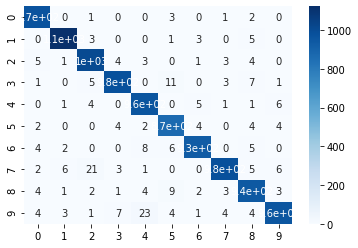

In [ ]:
ax_acc = test_model(MLP, 'q3_ckpt_MLP_ax_best',)
print('Test accuracy:',ax_acc,'%')

# SGD with momentum

### Without weights initialization

cuda Tesla K80
Epoch:0   Loss:0.654   Val error:0.216   Best val error:0.216
Epoch:1   Loss:0.196   Val error:0.141   Best val error:0.141
Epoch:2   Loss:0.143   Val error:0.105   Best val error:0.105
Epoch:3   Loss:0.115   Val error:0.095   Best val error:0.095
Epoch:4   Loss:0.096   Val error:0.087   Best val error:0.087
Epoch:5   Loss:0.082   Val error:0.092   Best val error:0.087
Epoch:6   Loss:0.072   Val error:0.083   Best val error:0.083
Epoch:7   Loss:0.065   Val error:0.074   Best val error:0.074
Epoch:8   Loss:0.06   Val error:0.089   Best val error:0.074
Epoch:9   Loss:0.054   Val error:0.073   Best val error:0.073


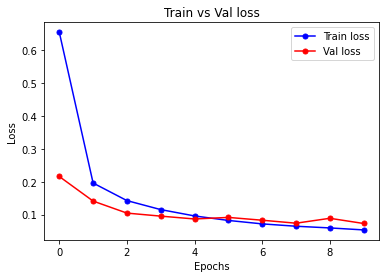

Best epoch: 9


In [ ]:
mlpb_trainer = MLP_Trainer(device, MLP, 'MLP_b', lr=0.01, epochs=10, optm='sgd', lr_decay=0.9, step=4, mom=0.9, weight_decay=1e-5)
b_best_epoch, b_losses, b_errors = mlpb_trainer.train()
plot_train(b_losses, b_errors)
print('Best epoch:',b_best_epoch)

Test accuracy: 97.72999999999999 %


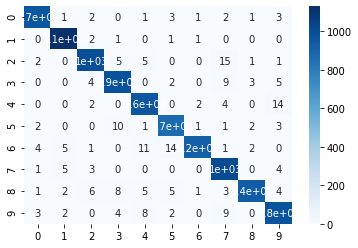

In [ ]:
b_acc = test_model(MLP, 'q3_ckpt_MLP_b_best')
print('Test accuracy:',b_acc,'%')

# ADAM optimizer

### Without weights initialization

cuda Tesla K80
Epoch:0   Loss:0.376   Val error:0.172   Best val error:0.172
Epoch:1   Loss:0.173   Val error:0.126   Best val error:0.126
Epoch:2   Loss:0.134   Val error:0.108   Best val error:0.108
Epoch:3   Loss:0.114   Val error:0.1   Best val error:0.1
Epoch:4   Loss:0.099   Val error:0.084   Best val error:0.084
Epoch:5   Loss:0.091   Val error:0.09   Best val error:0.084
Epoch:6   Loss:0.081   Val error:0.082   Best val error:0.082
Epoch:7   Loss:0.075   Val error:0.093   Best val error:0.082
Epoch:8   Loss:0.07   Val error:0.067   Best val error:0.067
Epoch:9   Loss:0.065   Val error:0.088   Best val error:0.067


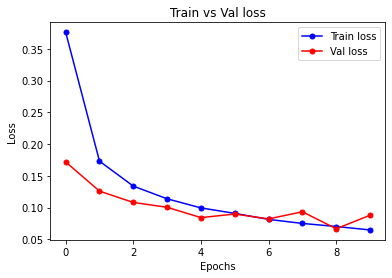

Best epoch: 8


In [ ]:
mlpc_trainer = MLP_Trainer(device, MLP, 'MLP_c', lr=0.001, epochs=10, optm='adam', lr_decay=0.9, step=4, mom=0.9, weight_decay=1e-5)
c_best_epoch, c_losses, c_errors = mlpc_trainer.train()
plot_train(c_losses, c_errors)
print('Best epoch:',c_best_epoch)

Test accuracy: 98.06 %


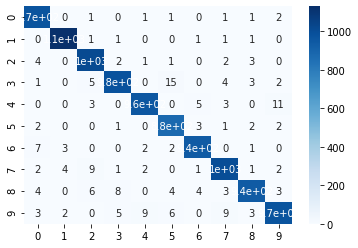

In [ ]:
c_acc = test_model(MLP, 'q3_ckpt_MLP_c_best')
print('Test accuracy:',c_acc,'%')

### ADAM with uniform weights initialization

cuda Tesla K80
Epoch:0   Loss:2.354   Val error:2.344   Best val error:2.344
Epoch:1   Loss:2.339   Val error:2.331   Best val error:2.331
Epoch:2   Loss:2.327   Val error:2.322   Best val error:2.322
Epoch:3   Loss:2.319   Val error:2.315   Best val error:2.315
Epoch:4   Loss:2.313   Val error:2.31   Best val error:2.31
Epoch:5   Loss:2.309   Val error:2.307   Best val error:2.307
Epoch:6   Loss:2.306   Val error:2.305   Best val error:2.305
Epoch:7   Loss:2.305   Val error:2.303   Best val error:2.303
Epoch:8   Loss:2.303   Val error:2.303   Best val error:2.303
Epoch:9   Loss:2.303   Val error:2.302   Best val error:2.302


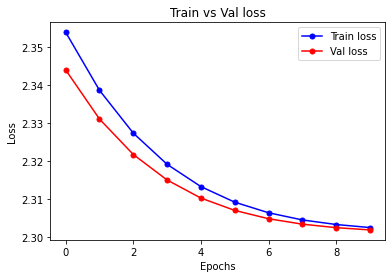

Best epoch: 9


In [ ]:
mlpcu_trainer = MLP_Trainer(device, MLP, 'MLP_cu', init_wts='u', lr=0.0001, epochs=10, optm='adam', lr_decay=0.9, step=4, mom=0.9, weight_decay=1e-5)
cu_best_epoch, cu_losses, cu_errors = mlpcu_trainer.train()
plot_train(cu_losses, cu_errors)
print('Best epoch:',cu_best_epoch)

In [ ]:
cu_acc = test_model(MLP, 'q3_ckpt_MLP_cu_best',False)
print('Test accuracy:',cu_acc,'%')

Test accuracy: 10.280000000000001 %


### ADAM with normal weights initialization

cuda Tesla T4
Epoch:0   Loss:4233.392   Val error:53.555   Best val error:53.555
Epoch:1   Loss:35.734   Val error:2.24   Best val error:2.24
Epoch:2   Loss:6.249   Val error:2.294   Best val error:2.24
Epoch:3   Loss:3.195   Val error:2.297   Best val error:2.24
Epoch:4   Loss:2.909   Val error:2.299   Best val error:2.24
Epoch:5   Loss:2.585   Val error:2.303   Best val error:2.24
Epoch:6   Loss:2.368   Val error:2.301   Best val error:2.24
Epoch:7   Loss:2.559   Val error:2.302   Best val error:2.24
Epoch:8   Loss:2.379   Val error:2.302   Best val error:2.24
Epoch:9   Loss:2.419   Val error:2.301   Best val error:2.24


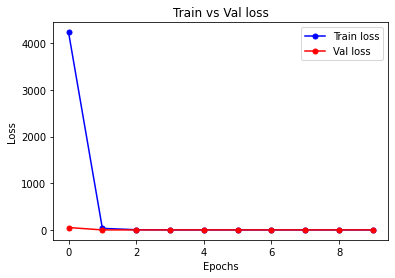

Best epoch: 1


In [ ]:
mlpcn_trainer = MLP_Trainer(device, MLP, 'MLP_cn', init_wts='n', lr=0.01, epochs=10, optm='adam', lr_decay=0.9, step=4, mom=0.9, weight_decay=1e-5)
cn_best_epoch, cn_losses, cn_errors = mlpcn_trainer.train()
plot_train(cn_losses, cn_errors)
print('Best epoch:',cn_best_epoch)

In [ ]:
cn_acc = test_model(MLP, 'q3_ckpt_MLP_cn_best', False)
print('Test accuracy:',cn_acc,'%')

Test accuracy: 13.94 %


### ADAM with Xavier's weights initialization



cuda Tesla T4
Epoch:0   Loss:0.731   Val error:0.276   Best val error:0.276
Epoch:1   Loss:0.316   Val error:0.203   Best val error:0.203
Epoch:2   Loss:0.232   Val error:0.16   Best val error:0.16
Epoch:3   Loss:0.193   Val error:0.138   Best val error:0.138
Epoch:4   Loss:0.161   Val error:0.123   Best val error:0.123
Epoch:5   Loss:0.14   Val error:0.108   Best val error:0.108
Epoch:6   Loss:0.125   Val error:0.098   Best val error:0.098
Epoch:7   Loss:0.111   Val error:0.095   Best val error:0.095
Epoch:8   Loss:0.1   Val error:0.085   Best val error:0.085
Epoch:9   Loss:0.089   Val error:0.081   Best val error:0.081


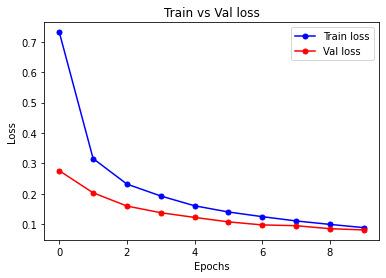

Best epoch: 9


In [ ]:
mlpcx_trainer = MLP_Trainer(device, MLP, 'MLP_cx', init_wts='x', lr=0.00005, epochs=10, optm='adam', lr_decay=0.9, step=4, mom=0.9, weight_decay=1e-5)
cx_best_epoch, cx_losses, cx_errors = mlpcx_trainer.train()
plot_train(cx_losses, cx_errors)
print('Best epoch:',cx_best_epoch)

Test accuracy: 97.35000000000001 %


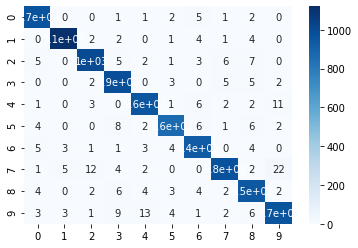

In [ ]:
cx_acc = test_model(MLP, 'q3_ckpt_MLP_cx_best')
print('Test accuracy:',cx_acc,'%')

# RMSProp optimizer

### Without weights initialization

cuda Tesla T4
Epoch:0   Loss:0.359   Val error:0.203   Best val error:0.203
Epoch:1   Loss:0.173   Val error:0.116   Best val error:0.116
Epoch:2   Loss:0.137   Val error:0.123   Best val error:0.116
Epoch:3   Loss:0.116   Val error:0.114   Best val error:0.114
Epoch:4   Loss:0.104   Val error:0.087   Best val error:0.087
Epoch:5   Loss:0.091   Val error:0.102   Best val error:0.087
Epoch:6   Loss:0.086   Val error:0.084   Best val error:0.084
Epoch:7   Loss:0.077   Val error:0.089   Best val error:0.084
Epoch:8   Loss:0.07   Val error:0.08   Best val error:0.08
Epoch:9   Loss:0.068   Val error:0.081   Best val error:0.08


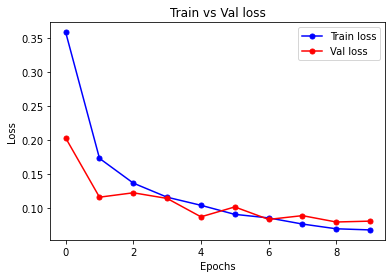

Best epoch: 8


In [ ]:
mlpd_trainer = MLP_Trainer(device, MLP, 'MLP_d', lr=0.0001, epochs=10, optm='rms', lr_decay=0.9, step=4, mom=0.9, weight_decay=1e-5)
d_best_epoch, d_losses, d_errors = mlpd_trainer.train()
plot_train(d_losses, d_errors)
print('Best epoch:',d_best_epoch)

Test accuracy: 97.69 %


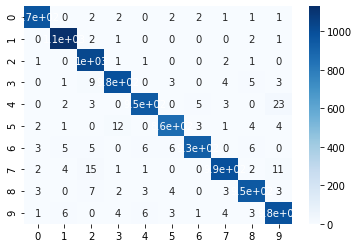

In [ ]:
d_acc = test_model(MLP, 'q3_ckpt_MLP_d_best',True)
print('Test accuracy:',d_acc,'%')

### Part1 Conclusion:


*   ADAM works best for our MLP network
*   Weights initialization may or may not work well. We need to choose wisely and tune the optimizer parameters accordingly.



# PART 2

In [ ]:
def test_p2model(model_class, ckpt, ae_class=None):
    model = model_class().cuda()
    # print(model)
    checkpoint = torch.load('q3_checkpoints/'+ckpt)
    model.load_state_dict(checkpoint['model_state_dict'])
    autoenc = AutoEncoder().cuda() if ae_class is None else HalfAutoEncoder().cuda()
    autoenc.load_state_dict(torch.load('q2_checkpoints_old/q2_ckpt_AE_c_best')['model_state_dict'])
    test_loader = DataLoader(test_dataset, 64, num_workers=2, pin_memory=True)  
    sm = nn.Softmax(dim=1)  
    total_correct = 0
    total_images = 0
    model.eval()        
    gt_labels = []
    pred_labels = []
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device).flatten(start_dim=1)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            encoding = autoenc(inputs)
            outputs = model(encoding)
            sm_outputs = sm(outputs)
            outputs = torch.argmax(outputs, dim=1)
            total_correct += (outputs == labels).sum().item()
            total_images += len(labels)
            gt_labels += labels.tolist()
            pred_labels += outputs.tolist()
        torch.cuda.empty_cache()
        gc.collect()
    model_accuracy = total_correct / total_images * 100
    conf_mat = confusion_matrix(gt_labels, pred_labels)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in range(10)], columns = [i for i in range(10)])
    plt.figure()
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    return model_accuracy


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256), #input
            nn.LeakyReLU(inplace=True), 
            nn.Linear(256, 128), #hidden
            nn.LeakyReLU(inplace=True),
            nn.Linear(128, 64), #hidden
            nn.LeakyReLU(inplace=True), 
            nn.Linear(64, 32), #output
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64), #input
            nn.ReLU(inplace=True), 
            nn.Linear(64, 128), #hidden
            nn.ReLU(inplace=True),
            nn.Linear(128, 256), #hidden
            nn.ReLU(inplace=True), 
            nn.Linear(256, 784), #output
            # nn.Sigmoid()
        )

    def forward(self,x):
        x = self.encoder(x)
        # print('after conv',x.shape)
        x = self.decoder(x)
        return x

In [ ]:
class HalfAutoEncoder(nn.Module):
    def __init__(self):
        super(HalfAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256), #input
            nn.LeakyReLU(inplace=True), 
            nn.Linear(256, 128), #hidden
            nn.LeakyReLU(inplace=True),
            nn.Linear(128, 64), #hidden
            nn.LeakyReLU(inplace=True), 
            nn.Linear(64, 32), #output
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64), #input
            nn.ReLU(inplace=True), 
            nn.Linear(64, 128), #hidden
            nn.ReLU(inplace=True),
            nn.Linear(128, 256), #hidden
            nn.ReLU(inplace=True), 
            nn.Linear(256, 784), #output
            # nn.Sigmoid()
        )

    def forward(self,x):
        x = self.encoder(x)
        # print('after conv',x.shape)
        # x = self.decoder(x)
        return x

In [ ]:
class AEMLP_Trainer(object):
    def __init__(self, device, model_class, ckpt_name, load_ckpt=None, half=True, epochs=200, batch_size=64, lr=0.1, optm=None, mom=0.9, lr_decay=None, init_wts=None, step=4, weight_decay=0, trainset=train_dataset, valset=test_dataset):
        self.device = device
        self.lr =  lr
        self.step_size = step
        self.momentum = mom
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.start_epoch = 0
        self.epochs = epochs
        self.workers = 2
        self.seed = int(time.time())
        self.print_freq = 1
        self.checkpoint_path = load_ckpt #'q1_checkpoints/q1_ckpt_CNN_a_best2'
        self.best_error = 1e8
        self.best_epoch = 0
        self.ckpt_name = ckpt_name
        self.loss_history = []
        self.error_history = []
        self.trainset = trainset
        self.valset = valset
        self.init_weights = init_wts
        torch.cuda.manual_seed(self.seed)
        print(self.device,torch.cuda.get_device_name(0))

        self.model = model_class(self.init_weights).cuda() 
        self.autoenc = AutoEncoder().cuda() if half is False else HalfAutoEncoder().cuda()
        self.autoenc.load_state_dict(torch.load('q2_checkpoints_old/q2_ckpt_AE_c_best')['model_state_dict'])
        # print(self.model)
        if optm=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optm=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        elif optm=='rms':
            self.optimizer = torch.optim.RMSprop(self.model.parameters(), self.lr, momentum=self.momentum)
        self.criterion = nn.CrossEntropyLoss().cuda()
        # self.scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.lr_decay)
        
        if self.checkpoint_path:
            checkpoint = torch.load(self.checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']+1
            loss = checkpoint['loss']
            self.best_error = checkpoint['best_error']
            self.best_epoch = checkpoint['best_epoch']
        
    def train(self):
        for epoch in range(self.start_epoch, self.epochs):
            loss = self.train_epoch(epoch)
            if epoch%1 != 0:
                print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)))
                continue
            error = self.validate(epoch)
            if error < self.best_error:
                is_best = True
                self.best_epoch = epoch
            else:
                is_best = False
            self.loss_history.append(loss)
            self.error_history.append(error)
            self.best_error = min(error, self.best_error)
            print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)),'  Val error:'+str(round(error,3)),'  Best val error:'+str(round(self.best_error,3)))
            save_checkpoint({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': loss,
                'best_error': self.best_error,
                'best_epoch': self.best_epoch
            }, is_best, epoch, self.ckpt_name)
            # self.scheduler.step()
            self.expo_anneal_lr(epoch)
        return self.best_epoch, self.loss_history, self.error_history

    def train_epoch(self, cur_epoch):
        train_loader = DataLoader(self.trainset, self.batch_size, shuffle=True, num_workers=self.workers, pin_memory=True)        
        self.model.train()  
        self.autoenc.eval()      
        losses = 0
        out_imgs = None
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(self.device).flatten(start_dim=1)
            labels = labels.to(self.device)
            # print(inputs.shape,labels.shape)
            with torch.set_grad_enabled(True):
                encoding = self.autoenc(inputs)
                outputs = self.model(encoding)
                loss = self.criterion(outputs, labels)
                losses += loss.detach().cpu().item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            torch.cuda.empty_cache()
            gc.collect()
        return losses/len(train_loader)
    
    def validate(self, cur_epoch):
        val_loader = DataLoader(self.valset, self.batch_size, num_workers=self.workers, pin_memory=True)        
        self.model.eval() 
        self.autoenc.eval()       
        errors = 0
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(self.device).flatten(start_dim=1)
            labels = labels.to(self.device)
            with torch.set_grad_enabled(False):
                encoding = self.autoenc(inputs)
                outputs = self.model(encoding)
                error = self.criterion(outputs, labels)
                errors += error.detach().cpu().item()
            torch.cuda.empty_cache()
            gc.collect()
        return errors/len(val_loader)

    def expo_anneal_lr(self, epoch):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr * self.lr_decay**(epoch/self.epochs)
            # print('LR adjusted')

### Training on the output of the encoder (latent features)

In [ ]:
'''Changing input size of MLP'''

class HMLP(nn.Module):
    def __init__(self,init_weights=None):
        super(HMLP, self).__init__()
        self.denselayers = nn.Sequential(
            nn.Linear(32, 512), #input
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 256), #hidden
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 128), #hidden
            nn.LeakyReLU(inplace=True), 
            nn.Dropout(0.1),
            nn.Linear(128, 64), #hidden
            nn.ReLU(inplace=True), 
            nn.Linear(64, 10), #output
        )
        self.init_weights = init_weights
        if self.init_weights:
            self._initialize_weights()

    def forward(self,x):
        x = self.denselayers(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Linear):
                if self.init_weights=='x':
                    torch.nn.init.xavier_normal_(m.weight)
                elif self.init_weights=='u':
                    torch.nn.init.uniform_(m.weight)
                elif self.init_weights=='n':
                    torch.nn.init.normal_(m.weight)
                    # print("init n")
                if m.bias is not None:
                    nn.init.uniform_(m.bias)

cuda Tesla K80
Epoch:0   Loss:0.243   Val error:0.114   Best val error:0.114
Epoch:1   Loss:0.116   Val error:0.106   Best val error:0.106
Epoch:2   Loss:0.094   Val error:0.076   Best val error:0.076
Epoch:3   Loss:0.082   Val error:0.065   Best val error:0.065
Epoch:4   Loss:0.069   Val error:0.082   Best val error:0.065
Epoch:5   Loss:0.064   Val error:0.1   Best val error:0.065
Epoch:6   Loss:0.056   Val error:0.065   Best val error:0.065
Epoch:7   Loss:0.056   Val error:0.069   Best val error:0.065
Epoch:8   Loss:0.047   Val error:0.075   Best val error:0.065
Epoch:9   Loss:0.046   Val error:0.064   Best val error:0.064


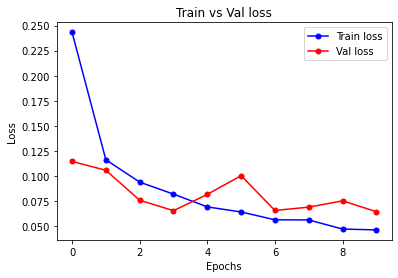

Best epoch: 9


In [ ]:
haemlp_trainer = AEMLP_Trainer(device, HMLP, 'HAEMLP', half=True, lr=0.002, epochs=10, optm='adam', lr_decay=0.9, step=4, mom=0.9, weight_decay=1e-5)
hm_best_epoch, hm_losses, hm_errors = haemlp_trainer.train()
plot_train(hm_losses, hm_errors)
print('Best epoch:',hm_best_epoch)

Test accuracy: 98.3 %


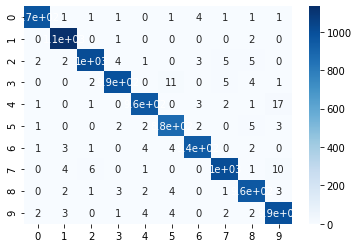

In [ ]:
hm_acc = test_p2model(HMLP, 'q3_ckpt_HAEMLP_best', 'half')
print('Test accuracy:',hm_acc,'%')

### Training on the output of the decoder 

cuda Tesla K80
Epoch:0   Loss:0.363   Val error:0.172   Best val error:0.172
Epoch:1   Loss:0.194   Val error:0.158   Best val error:0.158
Epoch:2   Loss:0.158   Val error:0.126   Best val error:0.126
Epoch:3   Loss:0.142   Val error:0.128   Best val error:0.126
Epoch:4   Loss:0.127   Val error:0.105   Best val error:0.105
Epoch:5   Loss:0.119   Val error:0.104   Best val error:0.104
Epoch:6   Loss:0.114   Val error:0.115   Best val error:0.104
Epoch:7   Loss:0.102   Val error:0.097   Best val error:0.097
Epoch:8   Loss:0.102   Val error:0.102   Best val error:0.097
Epoch:9   Loss:0.095   Val error:0.093   Best val error:0.093


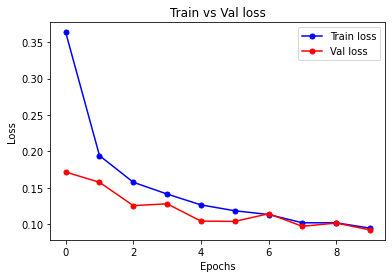

Best epoch: 9


In [ ]:
aemlp_trainer = AEMLP_Trainer(device, MLP, 'AEMLP', half=False, lr=0.002, epochs=10, optm='adam', lr_decay=0.9, step=4, mom=0.9, weight_decay=1e-5)
am_best_epoch, am_losses, am_errors = aemlp_trainer.train()
plot_train(am_losses, am_errors)
print('Best epoch:',am_best_epoch)

Test accuracy: 97.3 %


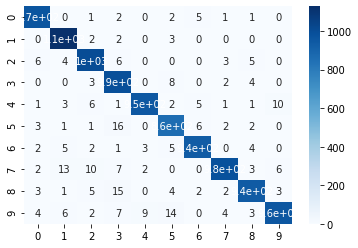

In [ ]:
am_acc = test_p2model(MLP, 'q3_ckpt_AEMLP_best')
print('Test accuracy:',am_acc,'%')

Accuracy of the MLP trained on the latent features of the autoencoder is comaprable to the accuracy of the MLP trained on original images as input.